In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
elettricity_data = pd.read_csv("citylearn_challenge_2023_phase_1/Building_1.csv")
carbon_data = pd.read_csv("citylearn_challenge_2023_phase_1/carbon_intensity.csv")

In [3]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(elettricity_data)
y_scaled = scaler_y.fit_transform(carbon_data)

In [4]:
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
time_steps = 24
X_sequences, y_sequences = create_sequences(x_scaled, y_scaled, time_steps)

In [6]:
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.25, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [7]:
def transformer_encoder (inputs, head_size, num_heads, ff_dim, dropout = 0):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dropout(dropout)(ffn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)

    return LayerNormalization(epsilon=1e-6)(ffn_output + out1)

In [8]:
inputs = Input(shape=(time_steps, X_train.shape[2]))

In [11]:
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[metrics.mae])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 15)    │     16,143 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 15)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 15)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 15)    │         30 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 24, 128)   │      2,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 24, 15)    │      1,935 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 15)    │          0 │ dense_5[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 15)    │         30 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24, 64)    │      1,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 24, 1)     │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,275 (83.11 KB)

 Trainable params: 21,275 (83.11 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs = 150, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.3700 - mean_absolute_error: 0.4949 - val_loss: 0.0644 - val_mean_absolute_error: 0.2083
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0651 - mean_absolute_error: 0.2076 - val_loss: 0.0566 - val_mean_absolute_error: 0.1895
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0487 - mean_absolute_error: 0.1748 - val_loss: 0.0532 - val_mean_absolute_error: 0.1930
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0521 - mean_absolute_error: 0.1880 - val_loss: 0.0558 - val_mean_absolute_error: 0.1877
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0556 - mean_absolute_error: 0.1858 - val_loss: 0.0511 - val_mean_absolute_error: 0.1893
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0544 - mean_absolute_error: 0.1942 - val_loss: 0.0484 - val_mean_absolute_error: 0.1813
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0472 - mean_absolute_error: 0.1785 - v

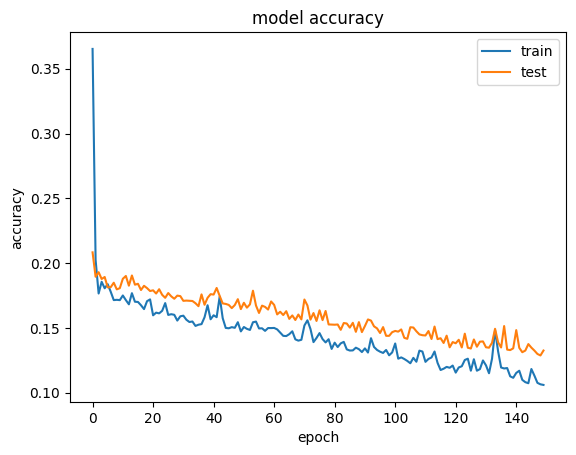

In [13]:
# Summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
def RMSE(real, pred):
    return sqrt(mean_squared_error(real, pred))

def NRMSE(real, pred):
    return sqrt(mean_squared_error(real, pred)/(real.max() - real.min()))

In [18]:
pred = model.predict(X_test)
pred = pred[:, -1, 0]

rmse = RMSE(y_test, pred)
nrmse = NRMSE(y_test, pred)

print("rmse: ", rmse, "  nrmse: ", nrmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
rmse:  0.1704638868612062   nrmse:  0.17649756297101407


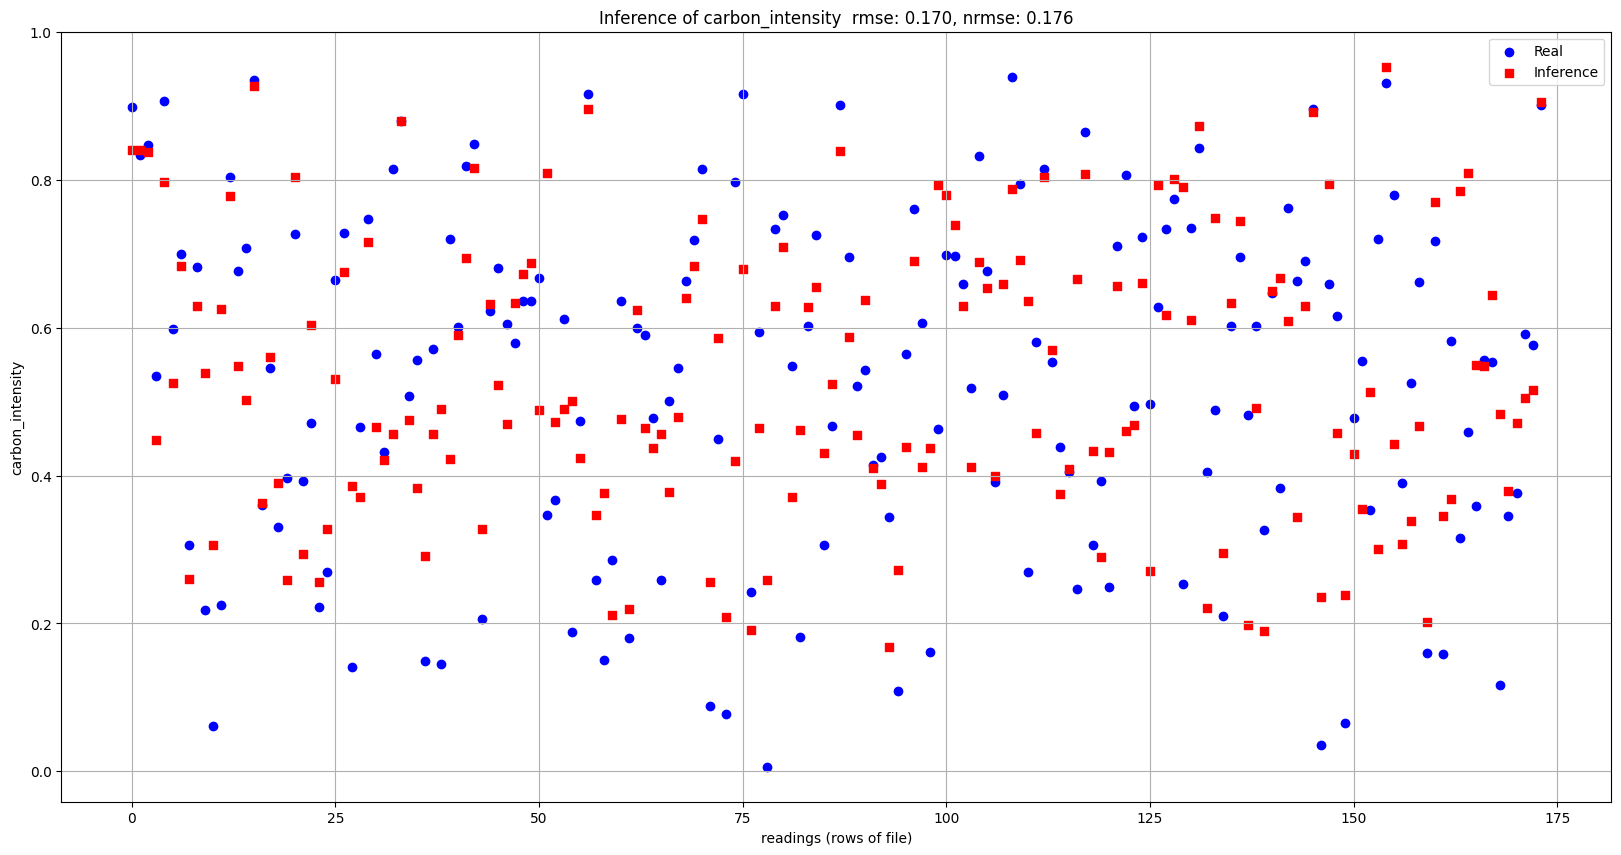

In [21]:
my_x=np.arange(0,len(X_test[:,0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of carbon_intensity  rmse: {rmse:.3f}, nrmse: {nrmse:.3f}')
plt.ylabel('carbon_intensity')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

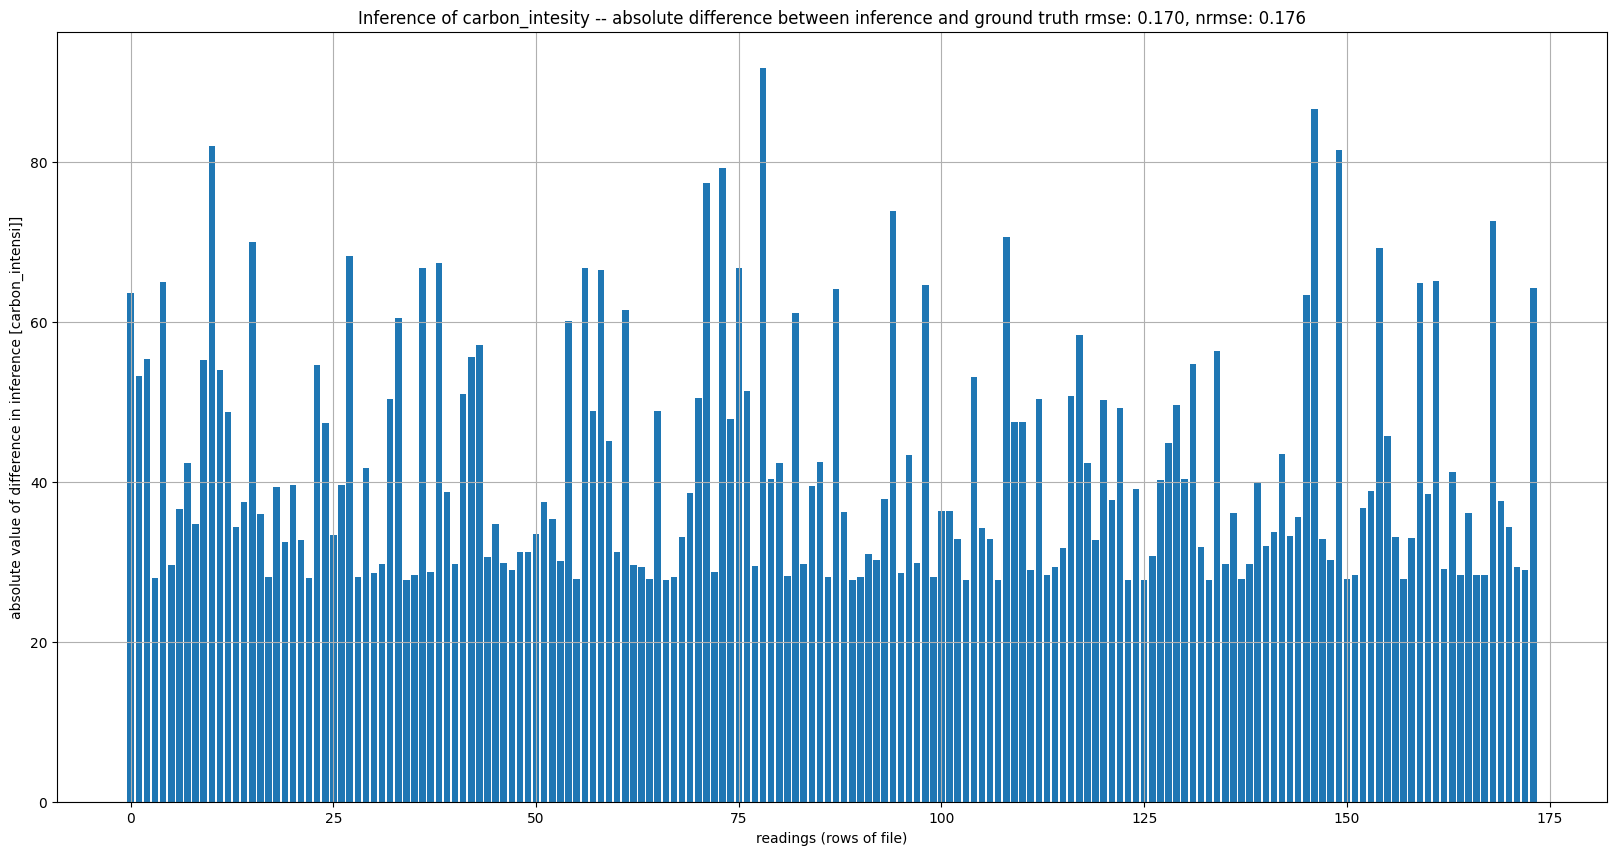

In [23]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)
my_d = np.sum(my_d, axis=1)

plt.bar(my_x,my_d)
plt.title(f'Inference of carbon_intesity -- absolute difference between inference and ground truth rmse: {rmse:.3f}, nrmse: {nrmse:.3f}')
plt.ylabel(f'absolute value of difference in inference [carbon_intensi]]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()